In [ ]:
# check prior predictive (data and summaries)
## %% Setup
from __future__ import annotations

import pathlib as pl
import sys
from collections.abc import Callable

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

try:
    import precond_npe_misspec  # noqa: F401
except Exception:
    sys.path.append(str(pl.Path.cwd() / "src"))

from precond_npe_misspec.examples.alpha_stable_sv import (
    assumed_dgp,
    fit_aux_beta_mle,
    make_summaries,
    prior_sample,
    wide_prior_sample,
)


# Optional: real data loader (S&P 500). Falls back to synthetic if download fails.
def load_sp500_returns_yahoo(
    start: str = "2013-01-02",
    end: str = "2024-08-30",
    field: str = "Close",
    log_returns: bool = True,
    standardise: bool = True,
) -> jnp.ndarray:
    try:
        import yfinance as yf  # dependency exists in your pyproject

        df = yf.download(
            "^GSPC", start=start, end=end, auto_adjust=True, progress=False
        )
        if df.empty:
            raise RuntimeError("No Yahoo data.")
        px = df[field].astype("float64").to_numpy().ravel()
        r = np.diff(np.log(px)) if log_returns else np.diff(px) / px[:-1]
        if standardise:
            r = (r - r.mean()) / r.std(ddof=0)
        return jnp.asarray(r, dtype=jnp.float32)
    except Exception as e:
        print("Yahoo load failed -> synthetic fallback:", e)
        key = jax.random.key(0)
        th = jnp.array([0.95, 0.20, 1.30], dtype=jnp.float32)
        T = 1400
        y = assumed_dgp(jax.random.fold_in(key, 1), th, T=T, theta1=0.0, skew=0.0)
        return y.astype(jnp.float32)


# Config
SEED = 0
key = jax.random.key(SEED)
BETA_REF = jnp.array([0.05, 0.10, 0.85, 8.0], dtype=jnp.float32)

T = 2934
Raw returns fit:
  beta_hat: [1.0818794e+01 1.5093619e-01 1.0000000e-06 7.9590030e+00]
  ||score(beta_ref; y)||_inf = 19.693803787231445
  ||score(beta_hat; y)||_inf = 0.9996542930603027

Standardised returns fit:
  beta_hat: [0.0689299  0.25887954 0.7211205  7.9930224 ]
  ||score(beta_ref; y_std)||_inf = 0.758095383644104
  ||score(beta_hat; y_std)||_inf = 0.0726877748966217

Chosen AUX_BETA: [0.06892989575862885, 0.25887954235076904, 0.7211204767227173, 7.993022441864014]


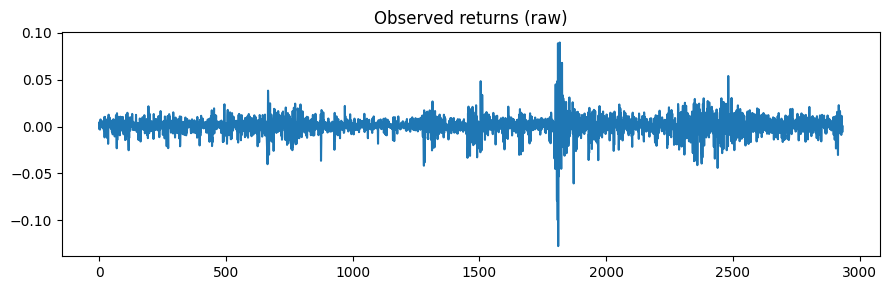

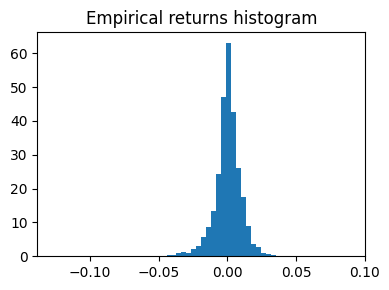

In [2]:
# %% 1) Auxiliary fit sanity
import matplotlib.pyplot as plt


def aux_fit_sanity(
    y: jnp.ndarray, init_beta: jnp.ndarray, steps: int, lr: float
) -> dict[str, jnp.ndarray | float]:
    beta_hat = fit_aux_beta_mle(y, init_beta=init_beta, steps=steps, lr=lr).astype(
        y.dtype
    )
    s_fun_ref = make_summaries(init_beta.astype(y.dtype))
    s_fun_hat = make_summaries(beta_hat)
    s_ref = s_fun_ref(y)
    s_hat = s_fun_hat(y)
    gnorm_ref = float(jnp.max(jnp.abs(s_ref)))
    gnorm_hat = float(jnp.max(jnp.abs(s_hat)))
    return {
        "beta_hat": beta_hat,
        "s_ref": s_ref,
        "s_hat": s_hat,
        "gnorm_ref": gnorm_ref,
        "gnorm_hat": gnorm_hat,
    }


# Load observed returns (try standardised and unstandardised)
y_raw = load_sp500_returns_yahoo(standardise=False)
y_std = (y_raw - jnp.mean(y_raw)) / (jnp.std(y_raw) + 1e-8)

print(f"T = {int(y_raw.shape[0])}")

# Quick fits
out_raw = aux_fit_sanity(y_raw, BETA_REF, steps=800, lr=3e-3)
out_std = aux_fit_sanity(y_std, BETA_REF, steps=3000, lr=3e-3)

print("Raw returns fit:")
print("  beta_hat:", out_raw["beta_hat"])
print("  ||score(beta_ref; y)||_inf =", out_raw["gnorm_ref"])
print("  ||score(beta_hat; y)||_inf =", out_raw["gnorm_hat"])

print("\nStandardised returns fit:")
print("  beta_hat:", out_std["beta_hat"])
print("  ||score(beta_ref; y_std)||_inf =", out_std["gnorm_ref"])
print("  ||score(beta_hat; y_std)||_inf =", out_std["gnorm_hat"])

# Choose which beta to use for summaries downstream
AUX_BETA = (
    out_std["beta_hat"]
    if out_std["gnorm_hat"] < out_raw["gnorm_hat"]
    else out_raw["beta_hat"]
)
print("\nChosen AUX_BETA:", AUX_BETA.tolist())

# Quick visuals
plt.figure(figsize=(9, 3))
plt.plot(np.asarray(y_raw))
plt.title("Observed returns (raw)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(4, 3))
plt.hist(np.asarray(y_raw), bins=60, density=True)
plt.title("Empirical returns histogram")
plt.tight_layout()
plt.show()

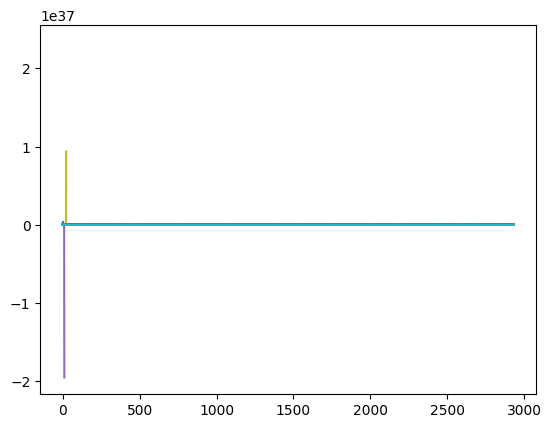

In [3]:
import matplotlib.pyplot as plt

import jax.random as random

key = random.key(1)
key, subkey = random.split(key)

T = int(y_raw.shape[0])
theta1 = 0.0
skew = 0.0


for _ in range(100):
    key, subkey = random.split(subkey)
    th = wide_prior_sample(subkey)
    key, subkey = random.split(subkey)
    x = assumed_dgp(subkey, th, T=T, theta1=theta1, skew=skew)
    plt.plot(x)

s_obs: [-14.104896545410156, -0.0972943902015686, -3.570711612701416, -0.01692339964210987]
pilot mean S: [-9.600621223449707, 0.2335948646068573, -2.4452672004699707, -0.05627712234854698]
pilot std  S: [7.077502250671387, 0.4554552435874939, 2.556370735168457, 0.069706991314888]
z_obs per dim: [-0.6364216208457947, -0.7265022397041321, -0.44025087356567383, 0.5645591616630554]


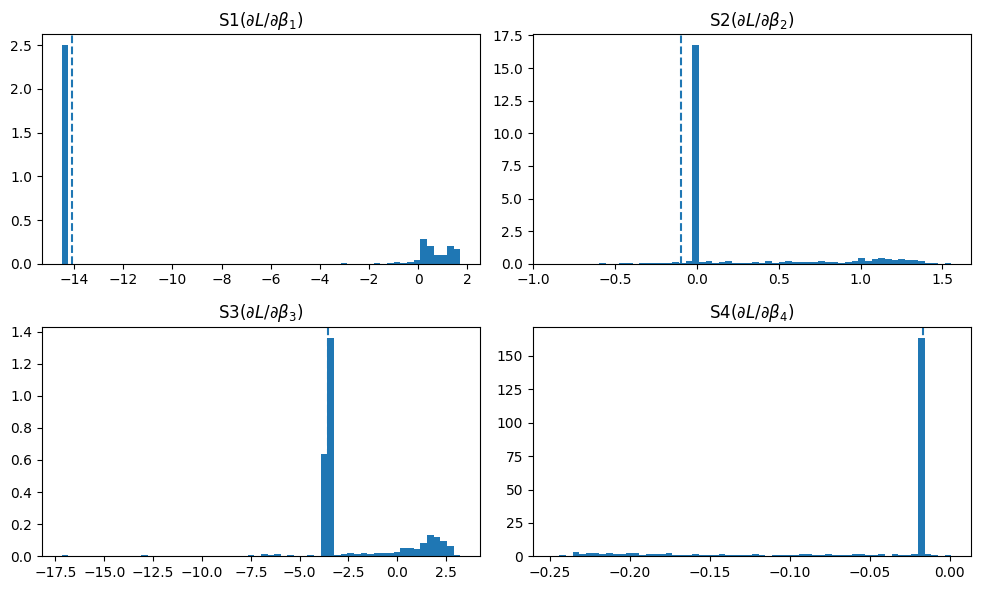

In [4]:
# %% 2) Prior-predictive diagnostics
import matplotlib.pyplot as plt


def simulate_pilot_S(
    key: jax.Array,
    N: int,
    T: int,
    theta1: float,
    skew: float,
    summaries: Callable[[jnp.ndarray], jnp.ndarray],
    batch_size: int = 512,
) -> tuple[jnp.ndarray, jnp.ndarray]:
    """Returns (thetas, S) with shapes (N,3) and (N,4)."""
    ths, Ss = [], []
    k_th, k_sim = jax.random.split(key)

    for start in range(0, N, batch_size):
        b = min(batch_size, N - start)
        idx = jnp.arange(start, start + b, dtype=jnp.uint32)
        th_keys = jax.vmap(lambda i: jax.random.fold_in(k_th, i))(idx)
        sm_keys = jax.vmap(lambda i: jax.random.fold_in(k_sim, i))(idx)
        th_b = jax.vmap(wide_prior_sample)(th_keys)
        x_b = jax.vmap(
            lambda kk, th: assumed_dgp(kk, th, T=T, theta1=theta1, skew=skew)
        )(sm_keys, th_b)
        S_b = jax.vmap(summaries)(x_b)
        ths.append(th_b)
        Ss.append(S_b)

    return jnp.concatenate(ths, 0), jnp.concatenate(Ss, 0)


# Build summary function at chosen AUX_BETA and compute s(y_obs)
summaries = make_summaries(AUX_BETA.astype(y_raw.dtype))
s_obs = summaries(y_raw)
print("s_obs:", s_obs.tolist())

# Pilot simulation
N_PILOT = 10000
thetas_pilot, S_pilot = simulate_pilot_S(
    key=jax.random.fold_in(key, 10),
    N=N_PILOT,
    T=int(y_raw.shape[0]),
    theta1=0.0,
    skew=0.0,
    summaries=summaries,
    batch_size=512,
)

mu_S = jnp.nanmean(S_pilot, 0)
sd_S = jnp.nanstd(S_pilot, 0) + 1e-8
z_obs = (s_obs - mu_S) / sd_S
print("pilot mean S:", mu_S.tolist())
print("pilot std  S:", sd_S.tolist())
print("z_obs per dim:", z_obs.tolist())

# Visual overlays
names = [
    r"S1($\partial L/\partial \beta_1$)",
    r"S2($\partial L/\partial \beta_2$)",
    r"S3($\partial L/\partial \beta_3$)",
    r"S4($\partial L/\partial \beta_4$)",
]
plt.figure(figsize=(10, 6))
for j in range(4):
    ax = plt.subplot(2, 2, j + 1)
    ax.hist(np.asarray(S_pilot[:, j]), bins=60, density=True)
    ax.axvline(float(s_obs[j]), linestyle="--")
    ax.set_title(f"{names[j]}")
plt.tight_layout()
plt.show()

In [5]:
# %% 3) Incompatibility metrics
# Per-dimension fraction of pilot summaries within |z| <= 2 around s_obs
Z = (S_pilot - s_obs[None, :]) / sd_S[None, :]
frac_within_2 = jnp.mean(jnp.abs(Z) <= 2.0, axis=0)
print("Fraction within |z|<=2 around s_obs (per dim):", frac_within_2.tolist())

# Simple table
tbl = pd.DataFrame(
    {
        "summary": ["S1", "S2", "S3", "S4"],
        "z_obs": np.asarray(z_obs),
        "frac_within_2": np.asarray(frac_within_2),
    }
)
tbl

Fraction within |z|<=2 around s_obs (per dim): [0.1070999950170517, 0.1251000016927719, 0.12809999287128448, 0.1273999959230423]


,summary,z_obs,frac_within_2
0,S1,-0.636422,0.1071
1,S2,-0.726502,0.1251
2,S3,-0.440251,0.1281
3,S4,0.564559,0.1274


Accepted: 1000
OLS slopes on standardised summaries (intercept, S1..S4): [1.5065594911575317, 0.011828538030385971, 0.027386637404561043, -0.03223903104662895, 0.026142627000808716]
Corr(theta4, S_j | accepted): [-0.04129483550786972, 0.06016363948583603, -0.004241323564201593, 0.0777992308139801]


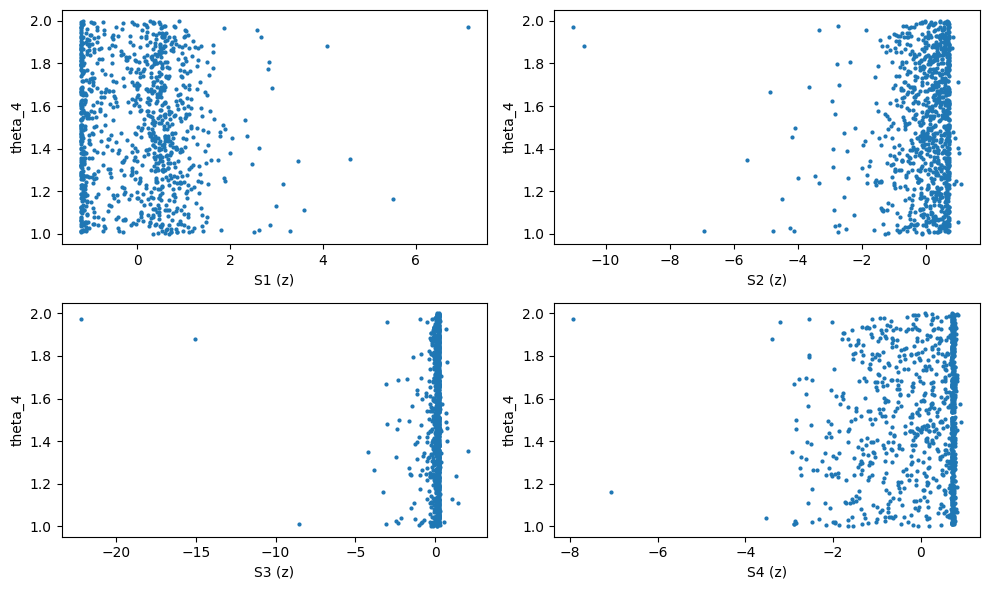

In [6]:
# %% 4) Mapping sensitivity: regress theta4 on standardised S (accepted set)
import matplotlib.pyplot as plt


def select_accepted_indices(
    S: jnp.ndarray, s_obs: jnp.ndarray, sd: jnp.ndarray, q: float = 0.1
) -> jnp.ndarray:
    Z = (S - s_obs[None, :]) / sd[None, :]
    d = jnp.sqrt(jnp.sum(Z**2, axis=1))
    n = S.shape[0]
    k = max(1, int(np.ceil(q * n)))
    idx = jnp.argpartition(d, k - 1)[:k]
    return idx[jnp.argsort(d[idx])]


idx_acc = select_accepted_indices(S_pilot, s_obs, sd_S, q=0.1)
S_acc = S_pilot[idx_acc]
th_acc = thetas_pilot[idx_acc]
print("Accepted:", int(S_acc.shape[0]))

# Standardise on accepted set for regression stability
mu_acc = jnp.mean(S_acc, 0)
sd_acc = jnp.std(S_acc, 0) + 1e-8
S_z = (S_acc - mu_acc) / sd_acc

# OLS with tiny ridge
X = jnp.concatenate([jnp.ones((S_z.shape[0], 1), S_z.dtype), S_z], axis=1)  # (n, 1+4)
y = th_acc[:, 2]  # theta_4
lam = 1e-6
beta = jnp.linalg.solve(X.T @ X + lam * jnp.eye(X.shape[1], dtype=X.dtype), X.T @ y)

# Correlations
corrs = jnp.array([jnp.corrcoef(S_z[:, j], y)[0, 1] for j in range(4)])

print("OLS slopes on standardised summaries (intercept, S1..S4):", beta.tolist())
print("Corr(theta4, S_j | accepted):", corrs.tolist())

# Quick visual: theta4 vs each S_j (standardised)
plt.figure(figsize=(10, 6))
for j in range(4):
    ax = plt.subplot(2, 2, j + 1)
    ax.scatter(np.asarray(S_z[:, j]), np.asarray(y), s=4)
    ax.set_xlabel(f"{['S1', 'S2', 'S3', 'S4'][j]} (z)")
    ax.set_ylabel("theta_4")
plt.tight_layout()
plt.show()

In [7]:
# A) Safe pilot summaries: drop NaN/inf rows before any stats
def finite_rows(X: jnp.ndarray) -> jnp.ndarray:
    m = jnp.all(jnp.isfinite(X), axis=1)
    return X[m]


thetas_pilot_safe = finite_rows(thetas_pilot)
S_pilot_safe = finite_rows(S_pilot)

mu_S = jnp.mean(S_pilot_safe, 0)
sd_S = jnp.std(S_pilot_safe, 0) + 1e-8
s_obs = summaries(y_raw)
z_obs = (s_obs - mu_S) / sd_S

print("pilot mean S:", mu_S.tolist())
print("pilot std  S:", sd_S.tolist())
print("z_obs:", z_obs.tolist())

pilot mean S: [-9.60062026977539, 0.2335948348045349, -2.4452672004699707, -0.05627712607383728]
pilot std  S: [7.077502250671387, 0.4554552435874939, 2.556370735168457, 0.069706991314888]
z_obs: [-0.6364217400550842, -0.7265021800994873, -0.44025087356567383, 0.564559280872345]


d S4 / d θ4 ≈ 0.0609361912777568


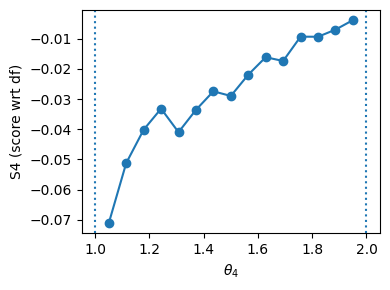

In [8]:
# B) Grid study: vary θ4, hold θ2,θ3 near centre of accepted cloud
import matplotlib.pyplot as plt

th2 = float(jnp.clip(jnp.median(thetas_pilot_safe[:, 0]), 0.85, 0.99))
th3 = float(jnp.clip(jnp.median(thetas_pilot_safe[:, 1]), 0.05, 0.4))
grid = jnp.linspace(1.05, 1.95, 15)
keys = jax.random.split(jax.random.key(123), grid.shape[0])


def s4_at_alpha(k, a):
    th = jnp.array([th2, th3, a])
    x = assumed_dgp(k, th, T=int(y_raw.shape[0]), theta1=0.0, skew=0.0)
    return make_summaries(AUX_BETA)(x)[3]  # S4


S4_grid = jax.vmap(s4_at_alpha)(keys, grid)
coef = np.polyfit(np.asarray(grid), np.asarray(S4_grid), 1)
print("d S4 / d θ4 ≈", coef[0])
plt.figure(figsize=(4, 3))
plt.plot(np.asarray(grid), np.asarray(S4_grid), marker="o")
plt.axvline(1.0, ls=":")
plt.axvline(2.0, ls=":")
plt.xlabel(r"$\theta_4$")
plt.ylabel("S4 (score wrt df)")
plt.tight_layout()
plt.show()

In [9]:
# C) Pilot‑scaled distance using pilot sd; keep top q% nearest to s_obs
def accept_indices(S: jnp.ndarray, s_obs: jnp.ndarray, sd: jnp.ndarray, q: float = 0.1):
    Z = (S - s_obs) / sd
    d = jnp.sqrt(jnp.sum(Z**2, axis=1))
    k = max(1, int(np.ceil(q * S.shape[0])))
    idx = jnp.argpartition(d, k - 1)[:k]
    return idx[jnp.argsort(d[idx])]


idx_acc = accept_indices(S_pilot_safe, s_obs, sd_S, q=0.1)
S_acc = S_pilot_safe[idx_acc]
th_acc = thetas_pilot_safe[idx_acc]

mu_acc, sd_acc = jnp.mean(S_acc, 0), jnp.std(S_acc, 0) + 1e-8
z_obs_acc = (s_obs - mu_acc) / sd_acc
print("Accepted:", int(S_acc.shape[0]))
print("z_obs (accepted stats):", z_obs_acc.tolist())

Accepted: 152
z_obs (accepted stats): [12.15953254699707, -16.485061645507812, 0.761350154876709, 2.934904098510742]


In [10]:
# D) Fit a conditional flow on S4 only; sample posterior at observed S4
import flowjax.bijections as bij
from flowjax.distributions import Normal
from flowjax.distributions import Transformed as _Transformed
from flowjax.flows import coupling_flow
from flowjax.train import fit_to_data

theta = th_acc  # (n,3)
s4 = S_acc[:, 3:4]  # (n,1)

# Whitening
th_mu, th_sd = jnp.mean(theta, 0), jnp.std(theta, 0) + 1e-8
s4_mu, s4_sd = jnp.mean(s4, 0), jnp.std(s4, 0) + 1e-8
th_p, s4_p = (theta - th_mu) / th_sd, (s4 - s4_mu) / s4_sd

# Flow
key = jax.random.key(2025)
flow0 = coupling_flow(
    key=key,
    base_dist=Normal(jnp.zeros(3)),
    transformer=bij.RationalQuadraticSpline(knots=10, interval=8.0),
    cond_dim=1,
    flow_layers=8,
    nn_width=128,
)
flow_fit, _ = fit_to_data(
    key=jax.random.split(key, 2)[1],
    dist=flow0,
    data=(th_p, s4_p),
    learning_rate=5e-4,
    max_epochs=400,
    max_patience=10,
    batch_size=512,
    show_progress=True,
)

# Undo θ whitening
Invert = bij.Invert
TransformedD = _Transformed
post = TransformedD(
    base_dist=flow_fit, bijection=Invert(bij.Affine(-th_mu / th_sd, 1.0 / th_sd))
)

# Condition at observed S4
s4_obs = s_obs[3:4]
s4_obs_p = (s4_obs - s4_mu) / s4_sd
th_samps = post.sample(jax.random.key(7), (20000,), condition=s4_obs_p)
q = jnp.quantile(th_samps, jnp.array([0.025, 0.5, 0.975]), axis=0)
print(
    "Masked q(θ|S4) -> θ4  median, 95%:",
    float(q[1, 2]),
    (float(q[0, 2]), float(q[2, 2])),
)

 13%|█▎        | 51/400 [00:17<01:59,  2.92it/s, train=3.78, val=4.76 (Max patience reached)]


Masked q(θ|S4) -> θ4  median, 95%: 4.067285537719727 (-0.6521481871604919, 5.058811664581299)


In [ ]:
# summary testing arena
# %% Shared helpers (run once)
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import numpy as np
from precond_npe_misspec.examples.alpha_stable_sv import assumed_dgp

EPS = 1e-8


def _mad(x: jnp.ndarray) -> jnp.ndarray:
    med = jnp.median(x)
    return jnp.median(jnp.abs(x - med)) + EPS


def _acf(x: jnp.ndarray, lag: int) -> jnp.ndarray:
    if lag >= x.size:
        return jnp.asarray(0.0, x.dtype)
    x0 = x - jnp.mean(x)
    v = jnp.std(x0) + EPS
    return jnp.corrcoef(x0[:-lag] / v, x0[lag:] / v)[0, 1]


def finite_rows(X: jnp.ndarray) -> jnp.ndarray:
    m = jnp.all(jnp.isfinite(X), axis=1)
    return X[m]


def simulate_pilot_S(
    key: jax.Array,
    N: int,
    T: int,
    theta1: float,
    skew: float,
    summaries,
    batch_size: int = 512,
):
    ths, Ss = [], []
    k_th, k_sm = jax.random.split(key)
    for start in range(0, N, batch_size):
        b = min(batch_size, N - start)
        idx = jnp.arange(start, start + b, dtype=jnp.uint32)
        th_keys = jax.vmap(lambda i: jax.random.fold_in(k_th, i))(idx)
        sm_keys = jax.vmap(lambda i: jax.random.fold_in(k_sm, i))(idx)
        th_b = jax.vmap(prior_sample)(th_keys)
        x_b = jax.vmap(
            lambda kk, th: assumed_dgp(kk, th, T=T, theta1=theta1, skew=skew)
        )(sm_keys, th_b)
        S_b = jax.vmap(summaries)(x_b)
        ths.append(th_b)
        Ss.append(S_b)
    return jnp.concatenate(ths, 0), jnp.concatenate(Ss, 0)


def plot_prior_predictive_summaries(
    name: str, summaries, y_obs: jnp.ndarray, N: int = 10_000, seed: int = 123
):
    s_obs = summaries(y_obs)
    _, S = simulate_pilot_S(
        jax.random.key(seed),
        N,
        int(y_obs.shape[0]),
        theta1=0.0,
        skew=0.0,
        summaries=summaries,
    )
    S = finite_rows(S)
    mu, sd = jnp.mean(S, 0), jnp.std(S, 0) + 1e-8
    print("sd: ", sd)
    z = (s_obs - mu) / sd
    print(f"{name}: s_obs = {s_obs.tolist()}")
    print(f"{name}: z_obs = {z.tolist()}")
    d = int(S.shape[1])
    ncol = 3 if d >= 3 else d
    nrow = int(np.ceil(d / ncol))
    plt.figure(figsize=(3.6 * ncol, 2.8 * nrow))
    for j in range(d):
        ax = plt.subplot(nrow, ncol, j + 1)
        ax.hist(np.asarray(S[:, j]), bins=60, density=True)
        ax.axvline(float(s_obs[j]), linestyle="--")
        ax.set_title(f"S{j + 1}")
    plt.tight_layout()
    plt.show()

sd:  [0.19384308 2.8838882  0.05119329 0.05476646 0.967838  ]
Bundle A: s_obs = [-5.387923240661621, 1.725103497505188, 0.1888207346200943, 0.09134288132190704, 3.109062433242798]
Bundle A: z_obs = [-27.536277770996094, -0.42448529601097107, -0.004783550277352333, -0.4675971567630768, 1.2591266632080078]


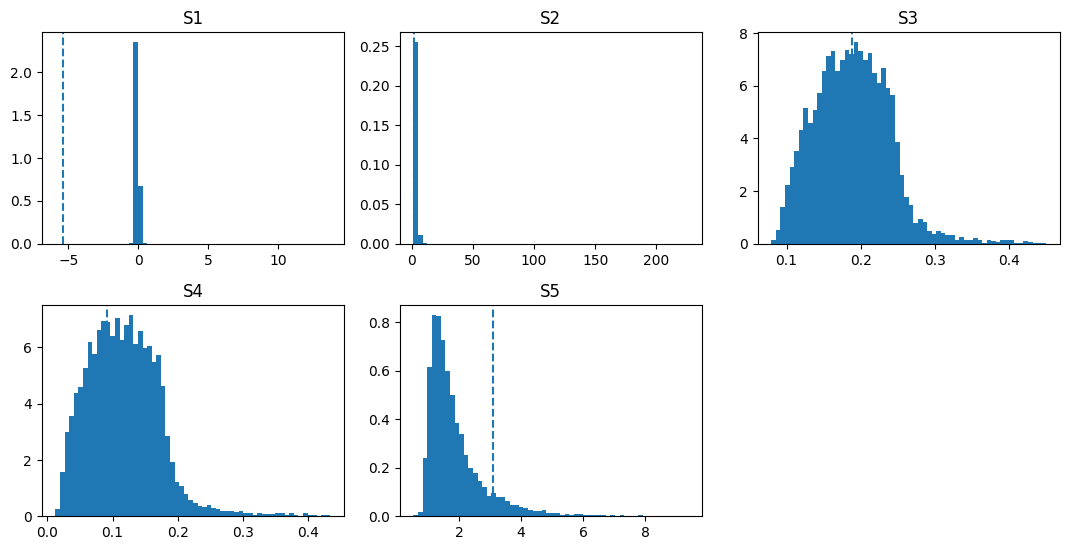

In [12]:
# %% Bundle A — Tail-only summaries
def make_summaries_tail_only():
    def summaries(y: jnp.ndarray) -> jnp.ndarray:
        mad = _mad(y)
        z = y / mad
        az = jnp.abs(z)
        q95 = jnp.quantile(az, 0.95)
        q99 = jnp.quantile(az, 0.99)
        tail_ratio = q99 / (q95 + EPS)
        p25 = jnp.mean(az > 2.5)
        p35 = jnp.mean(az > 3.5)
        # Hill on |z| with top 2%
        k = jnp.maximum(5, (az.size * 2) // 100)
        az_sorted = jnp.sort(az)
        top = az_sorted[-k:]
        xk = top[0]
        hill_inv_alpha = jnp.mean(jnp.log(top + EPS) - jnp.log(xk + EPS))
        hill_alpha = 1.0 / (hill_inv_alpha + EPS)
        return jnp.array(
            [jnp.log(mad), tail_ratio, p25, p35, hill_alpha], dtype=jnp.float32
        )

    return summaries


summaries_A = make_summaries_tail_only()
plot_prior_predictive_summaries("Bundle A", summaries_A, y_raw)

sd:  [1.2093022e+00 1.5202263e-01 6.4153127e-02 4.2416438e-02 1.4674889e+00
 5.5273857e-02 3.1513754e+04 2.0579211e-02 3.7120596e-01 1.3828867e+01
 4.1731097e+05]
Bundle B: s_obs = [-7.2719340324401855, -5.387923240661621, 0.3784346282482147, 0.3345080614089966, 1.725103497505188, 0.09134288132190704, 1.6771425008773804, -0.12571069598197937, 0.6157386302947998, 13.0, 0.08968323469161987]
Bundle B: z_obs = [-2.5242526531219482, -35.10727310180664, 5.82004976272583, 7.826473712921143, -0.8073392510414124, -0.4607318639755249, -0.016095509752631187, -6.119753837585449, -0.7706040740013123, 0.5191659331321716, -0.023969143629074097]


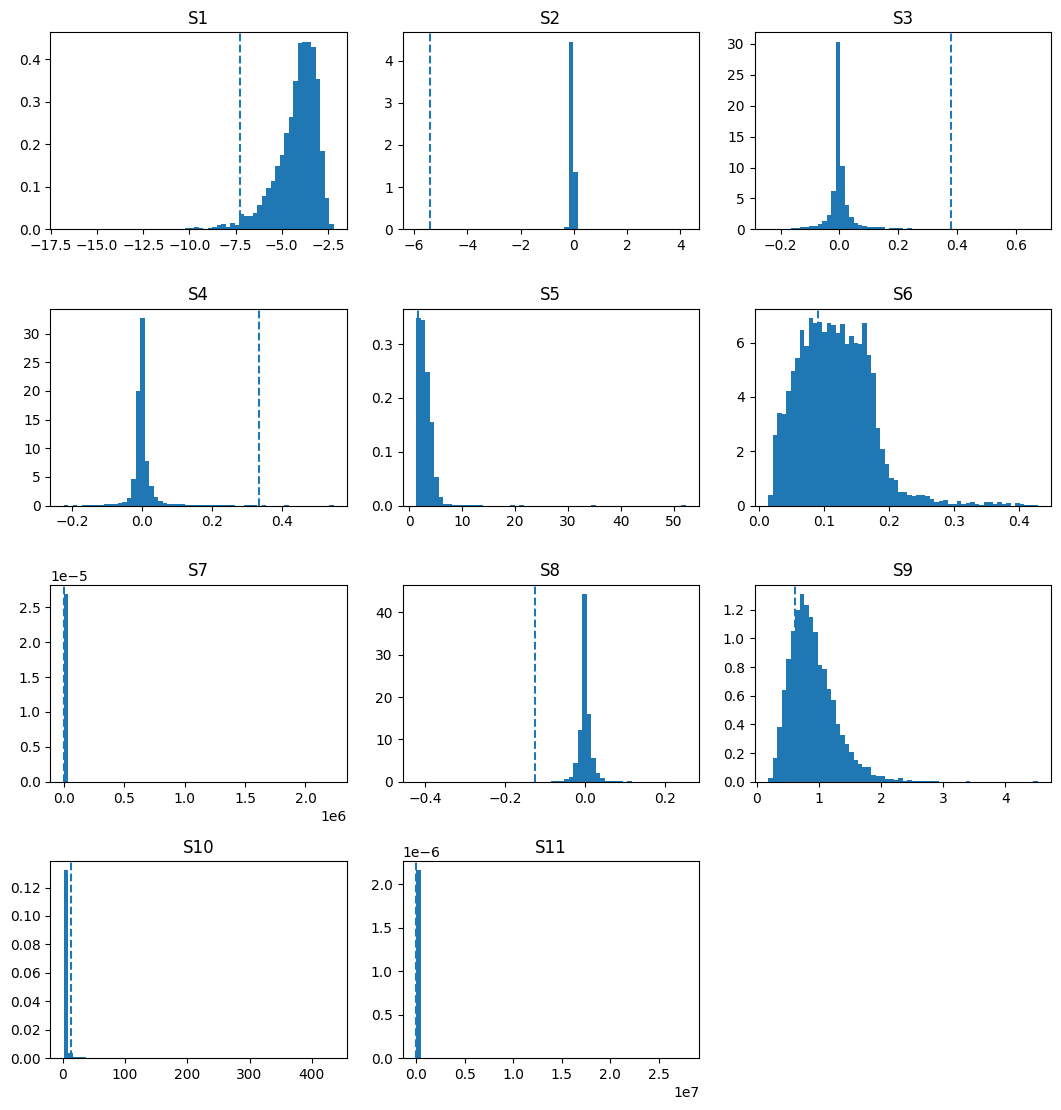

In [13]:
# %% Bundle B — Tail + clustering + incompatible (leverage, asymmetry)
def make_summaries_tail_vol_lev():
    def summaries(y: jnp.ndarray) -> jnp.ndarray:
        mad = _mad(y)
        med = jnp.median(y)
        z = y / mad
        az = jnp.abs(z)
        acf1 = _acf(az, 1)
        acf5 = _acf(az, 5) if az.size > 5 else jnp.asarray(0.0, az.dtype)
        q95 = jnp.quantile(az, 0.95)
        q99 = jnp.quantile(az, 0.99)
        q995 = jnp.quantile(az, 0.995)
        tail_ratio = q99 / (q95 + EPS)
        gap = (q995 - q99) / (q99 - q95 + EPS)
        p35 = jnp.mean(az > 3.5)
        me2 = jnp.where(
            jnp.any(az > 2.0),
            jnp.mean(jnp.maximum(az - 2.0, 0.0) * (az > 2.0))
            / (jnp.mean(az > 2.0) + EPS),
            0.0,
        )
        lev = (
            jnp.corrcoef(z[:-1], jnp.abs(z[1:]))[0, 1]
            if z.size > 1
            else jnp.asarray(0.0, z.dtype)
        )
        flags = (az > 2.5).astype(jnp.int32)

        def body(carry, f):
            cur, mx = carry
            cur = jnp.where(f == 1, cur + 1, 0)
            mx = jnp.maximum(mx, cur)
            return (cur, mx), mx

        (_, max_run), _ = jax.lax.scan(body, (0, 0), flags)
        max_run = jnp.asarray(max_run, dtype=jnp.float32)
        max_val = jnp.max(y)
        summaries_values = jnp.array(
            [
                jnp.log(med),
                jnp.log(mad),
                acf1,
                acf5,
                tail_ratio,
                p35,
                me2,
                lev,
                gap,
                max_run,
                max_val,
            ],
            dtype=jnp.float32,
        )
        return summaries_values

    return summaries


summaries_B = make_summaries_tail_vol_lev()
plot_prior_predictive_summaries("Bundle B", summaries_B, y_raw)

sd:  [0.19384308 0.05474447 0.05312623 0.9971597  0.37239102]
Bundle C: s_obs = [-5.387923240661621, 0.13394683599472046, 0.06748466193675995, 2.7998855113983154, 0.6157386302947998]
Bundle C: z_obs = [-27.536277770996094, -0.22213029861450195, -0.5466484427452087, 0.9114598631858826, -0.77549147605896]


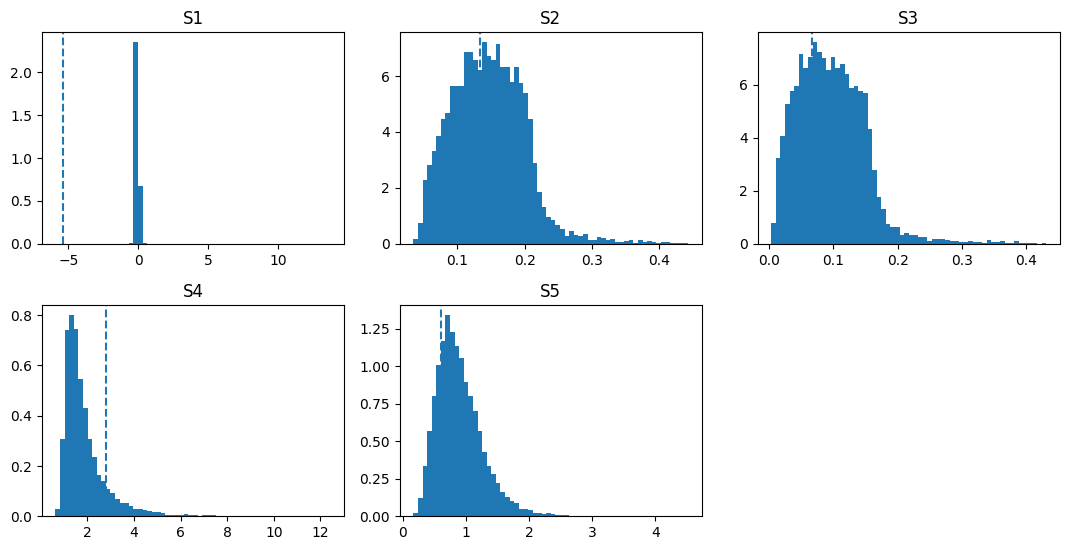

In [14]:
# %% Bundle C — Extreme-tail shape
def make_summaries_extreme_tail():
    def summaries(y: jnp.ndarray) -> jnp.ndarray:
        mad = _mad(y)
        z = y / mad
        az = jnp.abs(z)
        p3 = jnp.mean(az > 3.0)
        p4 = jnp.mean(az > 4.0)
        # Hill on |z| with top 1.5%
        k = jnp.maximum(5, (az.size * 15) // 1000)
        az_sorted = jnp.sort(az)
        top = az_sorted[-k:]
        xk = top[0]
        hill_inv_alpha = jnp.mean(jnp.log(top + EPS) - jnp.log(xk + EPS))
        hill_alpha = 1.0 / (hill_inv_alpha + EPS)
        q95 = jnp.quantile(az, 0.95)
        q99 = jnp.quantile(az, 0.99)
        q995 = jnp.quantile(az, 0.995)
        gap = (q995 - q99) / (q99 - q95 + EPS)
        return jnp.array([jnp.log(mad), p3, p4, hill_alpha, gap], dtype=jnp.float32)

    return summaries


summaries_C = make_summaries_extreme_tail()
plot_prior_predictive_summaries("Bundle C", summaries_C, y_raw)

sd:  [1.9384308e-01 6.4341888e-02 4.3253638e-02 2.8838882e+00 5.4766465e-02
 2.3402520e+06 2.1153918e-02]
Current: s_obs = [-5.387923240661621, 0.3784346282482147, 0.3345080614089966, 1.725103497505188, 0.09134288132190704, 1.6771425008773804, -0.12571075558662415]
Current: z_obs = [-27.536277770996094, 5.792567253112793, 7.66551399230957, -0.42448529601097107, -0.4675971567630768, -0.010496520437300205, -5.932920932769775]


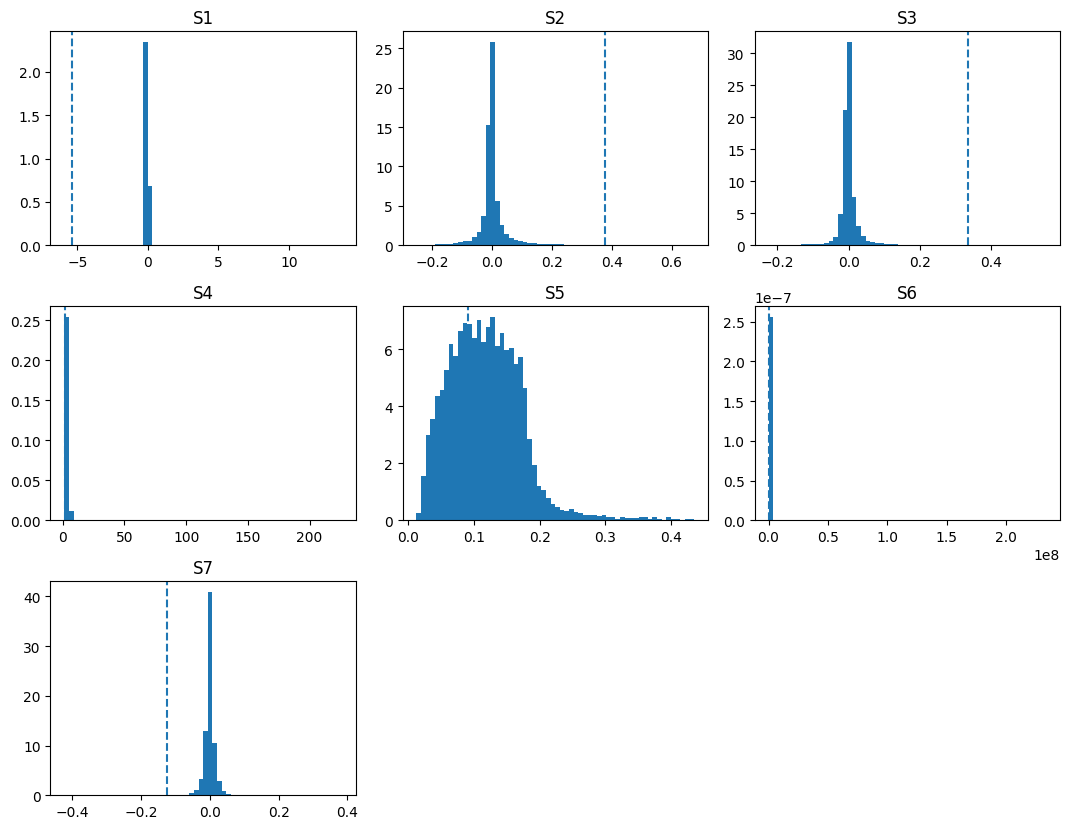

In [15]:
def _corr(x: jnp.ndarray, y: jnp.ndarray) -> jnp.ndarray:
    xm, ym = x - jnp.mean(x), y - jnp.mean(y)
    sx = jnp.std(xm) + EPS
    sy = jnp.std(ym) + EPS
    return jnp.mean(xm * ym) / (sx * sy)


def make_summaries():
    def summaries_fn(y):
        mad = _mad(y)
        z = y / mad
        az = jnp.abs(z)
        acf1 = _acf(az, 1)
        acf5 = _acf(az, 5) if az.size > 5 else jnp.asarray(0.0, az.dtype)
        q95 = jnp.quantile(az, 0.95)
        q99 = jnp.quantile(az, 0.99)
        tail_ratio = q99 / (q95 + EPS)
        p35 = jnp.mean(az > 3.5)
        has_ex2 = jnp.mean(az > 2.0)
        me2 = jnp.where(
            has_ex2 > 0,
            jnp.mean(jnp.maximum(az - 2.0, 0.0) * (az > 2.0)) / (has_ex2 + EPS),
            0.0,
        )
        lev = _corr(z[:-1], jnp.abs(z[1:])) if z.size > 1 else jnp.asarray(0.0, z.dtype)
        summaries = jnp.array(
            [jnp.log(mad), acf1, acf5, tail_ratio, p35, me2, lev], dtype=jnp.float32
        )
        return summaries

    return summaries_fn


summaries_current = make_summaries()
plot_prior_predictive_summaries("Current", summaries_current, y_raw)

In [19]:
def prior_sample2(key: jax.Array) -> jax.Array:
    lo = jnp.array((-3.0, -3.0, -3.0), dtype=jnp.float32)
    hi = jnp.array((3.0, 3.0, 3.0), dtype=jnp.float32)
    u = jax.random.uniform(key, shape=(3,))
    return lo + u * (hi - lo)  # (θ2, θ3, θ4)


def simulate_pilot_S(
    key: jax.Array,
    N: int,
    T: int,
    theta1: float,
    skew: float,
    summaries,
    batch_size: int = 512,
):
    ths, Ss = [], []
    k_th, k_sm = jax.random.split(key)
    for start in range(0, N, batch_size):
        b = min(batch_size, N - start)
        idx = jnp.arange(start, start + b, dtype=jnp.uint32)
        th_keys = jax.vmap(lambda i: jax.random.fold_in(k_th, i))(idx)
        sm_keys = jax.vmap(lambda i: jax.random.fold_in(k_sm, i))(idx)
        th_b = jax.vmap(prior_sample2)(th_keys)
        x_b = jax.vmap(
            lambda kk, th: assumed_dgp(kk, th, T=T, theta1=theta1, skew=skew)
        )(sm_keys, th_b)
        S_b = jax.vmap(summaries)(x_b)
        ths.append(th_b)
        Ss.append(S_b)
    return jnp.concatenate(ths, 0), jnp.concatenate(Ss, 0)

corr[S_j, θ_k]:
 [[-0.8535153   0.01223073 -0.01340575]
 [ 0.7273335  -0.01605155  0.18814394]
 [ 0.38762072  0.02120546  0.1078914 ]
 [ 0.03263648  0.02376902  0.00130469]
 [-0.7024042   0.01259099 -0.31895724]
 [ 0.04917847  0.01094252 -0.0753544 ]
 [-0.00403819  0.02940392 -0.01009483]]


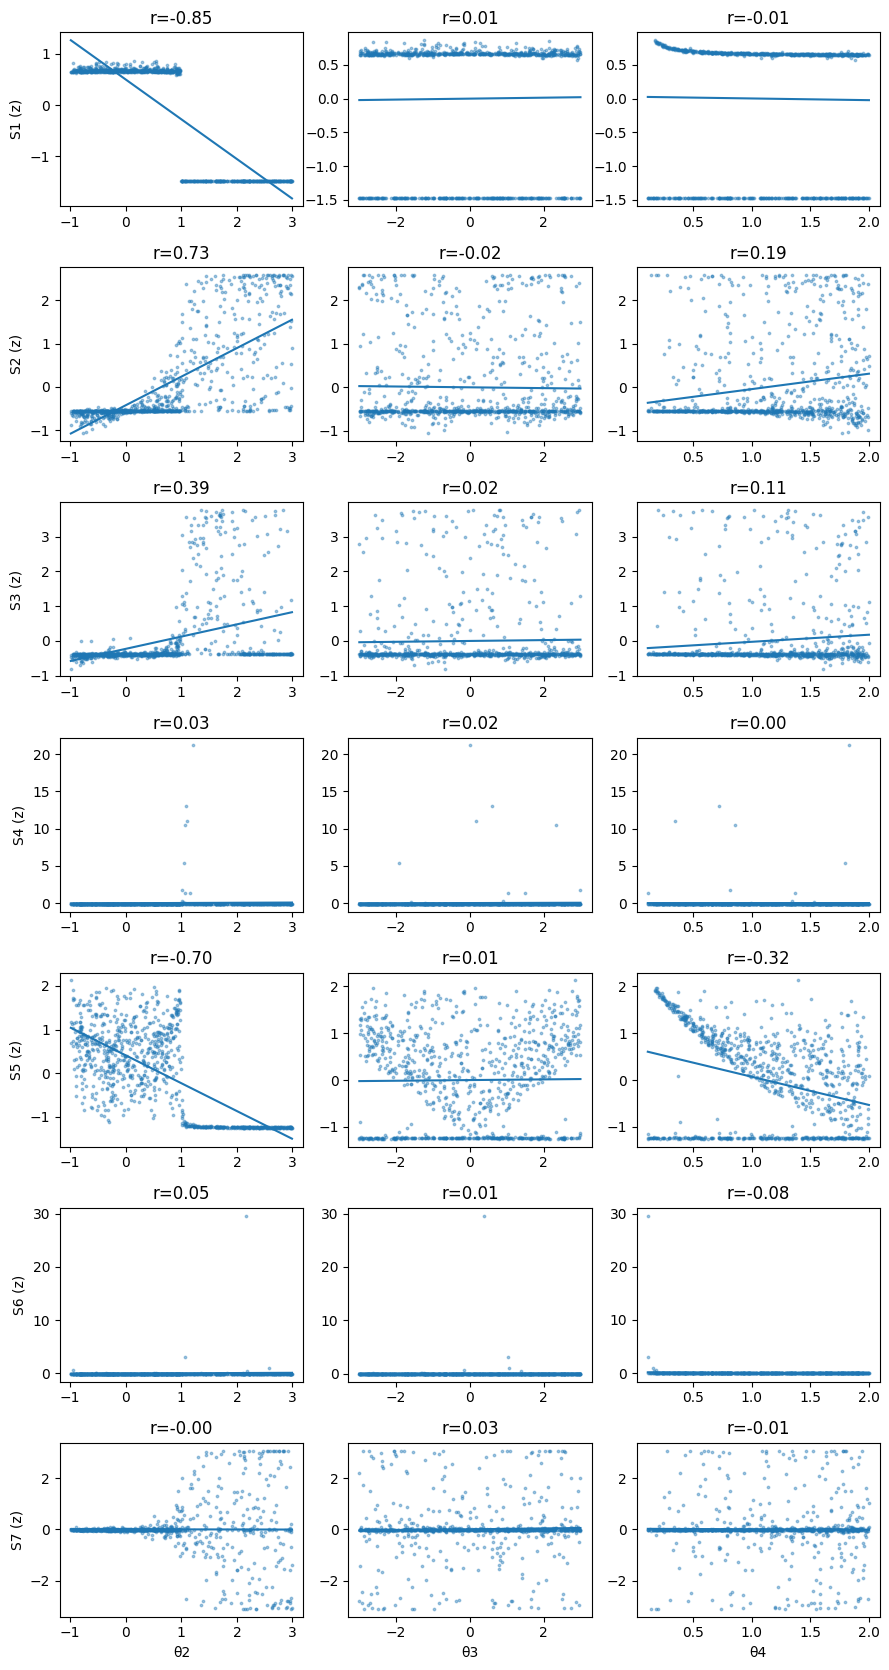

In [20]:
# TODO: PLOT SUMMARIES AGAINST EACH OF THE MODEL PARAMS
# Plot S_j vs each model parameter (θ2, θ3, θ4) for summaries_current
import matplotlib.pyplot as plt


def plot_S_vs_theta(
    summaries_fn: Callable[[jnp.ndarray], jnp.ndarray],
    T: int,
    N: int = 6000,
    seed: int = 2025,
) -> None:
    key = jax.random.key(seed)
    thetas, S = simulate_pilot_S(
        key=key, N=N, T=T, theta1=0.0, skew=0.0, summaries=summaries_fn, batch_size=512
    )
    m = jnp.all(jnp.isfinite(S), axis=1) & jnp.all(jnp.isfinite(thetas), axis=1)
    thetas, S = thetas[m], S[m]
    Sz = (S - jnp.mean(S, 0)) / (jnp.std(S, 0) + 1e-8)

    # Pearson correlations: corr[S_j, θ_k], shape (d,3)
    Szc, thc = Sz - jnp.mean(Sz, 0), thetas - jnp.mean(thetas, 0)
    corr = (Szc.T @ thc / Sz.shape[0]) / (
        (jnp.std(Sz, 0) + 1e-8)[:, None] * (jnp.std(thetas, 0) + 1e-8)[None, :]
    )
    print("corr[S_j, θ_k]:\n", np.asarray(corr))

    d = int(Sz.shape[1])
    fig, axes = plt.subplots(d, 3, figsize=(9, 2.4 * d), squeeze=False)
    for j in range(d):
        for k in range(3):
            ax = axes[j, k]
            x = np.asarray(thetas[:, k])
            y = np.asarray(Sz[:, j])
            ax.scatter(x, y, s=3, alpha=0.4)
            b = np.polyfit(x, y, 1)
            xs = np.linspace(x.min(), x.max(), 60)
            ax.plot(xs, b[0] * xs + b[1])
            if j == d - 1:
                ax.set_xlabel(f"θ{k + 2}")
            if k == 0:
                ax.set_ylabel(f"S{j + 1} (z)")
            ax.set_title(f"r={float(corr[j, k]):.2f}")
    plt.tight_layout()
    plt.show()


# Run on your current summaries and data length
plot_S_vs_theta(summaries_current, T=int(y_raw.shape[0]), N=6000, seed=2025)